Foreign Function Interface
====

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import numpy as np

Wrapping functions written in C
----

### Steps 

- Write the C header and implemntation files
- Write the Cython `.pxd` file to decalre C function signatures
- Write the Cython `.pyx` file to wrap the C functions for Python
- Write `setup.py` to automate buiding of the Python extension module
- Run `python setup.py build_ext --inplace` to build the module
- Import module in Python like any other Python module

### C header file

In [3]:
%%file c_math.h

#pragma once
double plus(double a, double b);
double mult(double a, double b);
double square(double a);
double acc(double *xs, int size);

Overwriting c_math.h


### C implementation file

In [4]:
%%file c_math.c
#include <math.h>
#include "c_math.h"

double plus(double a, double b) {
    return a + b;
};

double mult(double a, double b) {
    return a * b;
};

double square(double a) {
    return pow(a, 2);
};

double acc(double *xs, int size) {
    double s = 0;
    for (int i=0; i<size; i++) {
        s += xs[i];
    }
    return s;
};

Overwriting c_math.c


### Cython "header" file

The `.pxd` file is similar to a header file for Cython. In ohter words, we can `cimport <filename>.pxd` in the regular Cython `.pyx` files to get access to functions decalred in the `.pxd` files.

In [5]:
%%file cy_math.pxd

cdef extern from "c_math.h":
    double plus(double a, double b)
    double mult(double a, double b)
    double square(double a)
    double acc(double *xs, int size)

Overwriting cy_math.pxd


### Cython "implementation" file

Here is whhere we actaully wrap the C code for use in Python. Note especially how we handle passing in of arrays to a C funciton expecting a pointer to double using `typed memoryviews`.

In [6]:
%%file cy_math.pyx

cimport cy_math

def py_plus(double a, double b):
    return cy_math.plus(a, b)

def py_mult(double a, double b):
    return cy_math.mult(a, b)

def py_square(double a):
    return cy_math.square(a)

def py_sum(double[::1] xs):
    cdef int size = len(xs)
    return cy_math.acc(&xs[0], size)

Overwriting cy_math.pyx


### Build script `setup.py`

This is build script for Python, similar to a Makefile

In [7]:
%%file setup.py

from distutils.core import setup, Extension
from Cython.Build import cythonize
import numpy as np

ext = Extension("cy_math",
                sources=["cy_math.pyx", "c_math.c"],
                libraries=["m"],
                extra_compile_args=["-w",  "-std=c99"])

setup(name = "Math Funcs",
      ext_modules = cythonize(ext))

Overwriting setup.py


### Building an extension module

In [8]:
! python setup.py clean
! python setup.py -q build_ext --inplace

Compiling cy_math.pyx because it changed.
Cythonizing cy_math.pyx
running clean
removing 'build/temp.linux-x86_64-3.4' (and everything under it)
removing 'build'


In [9]:
! ls cy_math*

cy_math.c  cy_math.cpython-34m.so  cy_math.pxd	cy_math.pyx


### Using the extension module in Python

In [10]:
import cy_math
import numpy as np

print(cy_math.py_plus(3, 4))
print(cy_math.py_mult(3, 4))
print(cy_math.py_square(3))

xs = np.arange(10, dtype='float')
print(cy_math.py_sum(xs))

7.0
12.0
9.0
45.0


### Confirm that we are geting C speedups by comparing with pure Python accumulator

In [11]:
def acc(xs):
    s = 0
    for x in xs:
        s += x
    return s

In [12]:
import cy_math

xs = np.arange(1000000, dtype='float')
%timeit -r3 -n3 acc(xs)
%timeit -r3 -n3 cy_math.py_sum(xs)

3 loops, best of 3: 111 ms per loop
3 loops, best of 3: 1e+03 µs per loop


C++
----

This is almost similar to C. We will use Cython to wrap a simple funciton. 

In [13]:
%%file add.hpp
#pragma once
int add(int a, int b);

Overwriting add.hpp


In [14]:
%%file add.cpp
int add(int a, int b) {
    return a+b;
}

Overwriting add.cpp


In [15]:
%%file plus.pyx

cdef extern from 'add.cpp':
    int add(int a, int b)
    
def plus(a, b):
    return add(a, b)

Overwriting plus.pyx


#### Note that essentially the only differnece from C  is `language="C++"` and the floag `-std=c++11`

In [16]:
%%file setup.py 
from distutils.core import setup, Extension
from Cython.Build import cythonize

ext = Extension("plus",
                sources=["plus.pyx", "add.cpp"],
                extra_compile_args=["-w", "-std=c++11"])

setup(
    ext_modules = cythonize(
            ext,
            language="c++",        
      ))

Overwriting setup.py


In [17]:
%%bash
python setup.py -q build_ext --inplace

Compiling plus.pyx because it changed.
Cythonizing plus.pyx


cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++ [enabled by default]


In [18]:
import plus

plus.plus(3, 4)

7

Wrap an R function from libRmath using `ctypes`
----

R comes with a standalone C library of special functions and distributions, as described in the official documentation. These functions can be wrapped for use in Python.

### Building the Rmath standalone library

```bash
git clone https://github.com/JuliaLang/Rmath-julia.git
cd Rmath-julia/src
make
cd ../..
```

#### Functions to wrap

In [19]:
! grep "\s.norm(" Rmath-julia/include/Rmath.h

double	dnorm(double, double, double, int);
double	pnorm(double, double, double, int, int);
double	qnorm(double, double, double, int, int);
double	rnorm(double, double);


In [20]:
from ctypes import CDLL, c_int, c_double

In [21]:
%%bash
ls Rmath-julia/src/*so

Rmath-julia/src/libRmath-julia.so


In [22]:
lib = CDLL('Rmath-julia/src/libRmath-julia.so')

def rnorm(mu=0, sigma=1):
    lib.rnorm.argtypes = [c_double, c_double]
    lib.rnorm.restype  = c_double
    return lib.rnorm(mu, sigma)

def dnorm(x, mean=0, sd=1, log=0):
    lib.dnorm4.argtypes = [c_double, c_double, c_double, c_int]
    lib.dnorm4.restype  = c_double
    return lib.dnorm4(x, mean, sd, log)

def pnorm(q, mu=0, sd=1, lower_tail=1, log_p=0):
    lib.pnorm5.argtypes = [c_double, c_double, c_double, c_int, c_int]
    lib.pnorm5.restype  = c_double
    return lib.pnorm5(q, mu, sd, lower_tail, log_p)

def qnorm(p, mu=0, sd=1, lower_tail=1, log_p=0):
    lib.qnorm5.argtypes = [c_double, c_double, c_double, c_int, c_int]
    lib.qnorm5.restype  = c_double
    return lib.qnorm5(p, mu, sd, lower_tail, log_p)

In [23]:
pnorm(0, mu=2)

0.022750131948179212

In [24]:
qnorm(0.022750131948179212, mu=2)

0.0

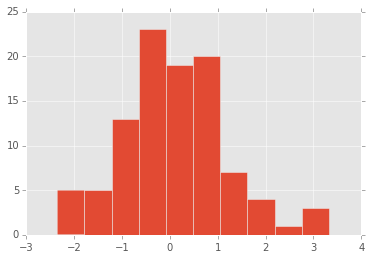

In [25]:
plt.hist([rnorm() for i in range(100)])
pass

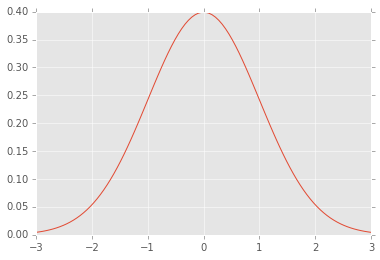

In [26]:
xs = np.linspace(-3,3,100)
plt.plot(xs, list(map(dnorm, xs)))
pass

### Using Cython to wrap standalone library

In [27]:
%%file rmath.pxd

cdef extern from "Rmath-julia/include/Rmath.h":
    double dnorm(double, double, double, int)
    double pnorm(double, double, double, int, int)
    double qnorm(double, double, double, int, int)
    double rnorm(double, double)

Overwriting rmath.pxd


In [28]:
%%file rmath.pyx

cimport rmath

def rnorm_(mu=0, sigma=1):
    return rmath.rnorm(mu, sigma)

def dnorm_(x, mean=0, sd=1, log=0):
    return rmath.dnorm(x, mean, sd, log)

def pnorm_(q, mu=0, sd=1, lower_tail=1, log_p=0):
    return rmath.pnorm(q, mu, sd, lower_tail, log_p)

def qnorm_(p, mu=0, sd=1, lower_tail=1, log_p=0):
    return rmath.qnorm(p, mu, sd, lower_tail, log_p)

Overwriting rmath.pyx


In [29]:
%%file setup.py 
from distutils.core import setup, Extension
from Cython.Build import cythonize

ext = Extension("rmath",
                sources=["rmath.pyx"],
                include_dirs=["Rmath-julia/include"],
                library_dirs=["Rmath-julia/src"],
                libraries=["Rmath-julia"],
                runtime_library_dirs=["Rmath-julia/src"],
                extra_compile_args=["-w",  "-std=c99", "-DMATHLIB_STANDALONE"],
                extra_link_args=[],
               )

setup(
    ext_modules = cythonize(
            ext
    ))

Overwriting setup.py


In [30]:
! python setup.py build_ext --inplace

Compiling rmath.pyx because it changed.
Cythonizing rmath.pyx
running build_ext
building 'rmath' extension
gcc -pthread -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -IRmath-julia/include -I/opt/conda/include/python3.4m -c rmath.c -o build/temp.linux-x86_64-3.4/rmath.o -w -std=c99 -DMATHLIB_STANDALONE
gcc -pthread -shared -L/opt/conda/lib -Wl,-rpath=/opt/conda/lib,--no-as-needed build/temp.linux-x86_64-3.4/rmath.o -LRmath-julia/src -L/opt/conda/lib -Wl,--enable-new-dtags,-RRmath-julia/src -lRmath-julia -lpython3.4m -o /home/jovyan/work/sta-663-2016/lectures/rmath.cpython-34m.so


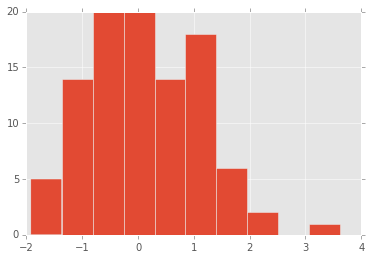

In [31]:
import rmath

plt.hist([rmath.rnorm_() for i in range(100)])
pass

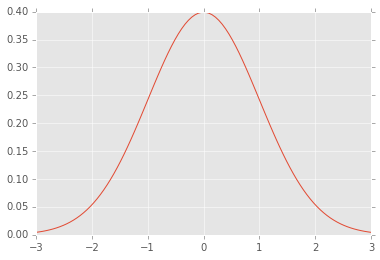

In [32]:
xs = np.linspace(-3,3,100)
plt.plot(xs, list(map(rmath.dnorm_, xs)))
pass

### `Cython` wrappers are faster than `ctypes`

In [33]:
%timeit pnorm(0, mu=2)
%timeit rmath.pnorm_(0, mu=2)

The slowest run took 258.12 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 4.06 µs per loop
The slowest run took 12.00 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 492 ns per loop


Fortran
----

In [34]:
! pip install fortran-magic

In [35]:
%load_ext fortranmagic

/opt/conda/lib/python3.4/site-packages/IPython/utils/path.py:264: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module
  warn("get_ipython_cache_dir has moved to the IPython.paths module")


In [36]:
%%fortran

subroutine fort_sum(N, s)
    integer*8, intent(in) :: N
    integer*8, intent(out) :: s
    integer*8 i
    s = 0
    do i = 1, N
        s = s + i*i
    end do
end 

In [37]:
fort_sum(10)

385

#### Antoher example from the [documentation](http://nbviewer.ipython.org/github/mgaitan/fortran_magic/blob/master/documentation.ipynb)

In [38]:
%%fortran --link lapack

subroutine solve(A, b, x, n)
    ! solve the matrix equation A*x=b using LAPACK
    implicit none

    real*8, dimension(n,n), intent(in) :: A
    real*8, dimension(n), intent(in) :: b
    real*8, dimension(n), intent(out) :: x

    integer :: pivot(n), ok

    integer, intent(in) :: n
    x = b

    ! find the solution using the LAPACK routine SGESV
    call DGESV(n, 1, A, n, pivot, x, n, ok)
    
end subroutine

In [39]:
A = np.array([[1, 2.5], [-3, 4]])
b = np.array([1, 2.5])

solve(A, b)

array([-0.19565217,  0.47826087])

Interfacing with R
----

In [40]:
%load_ext rpy2.ipython

/opt/conda/lib/python3.4/site-packages/rpy2/robjects/functions.py:106: UserWarning: Use suppressPackageStartupMessages to eliminate package startup messages.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


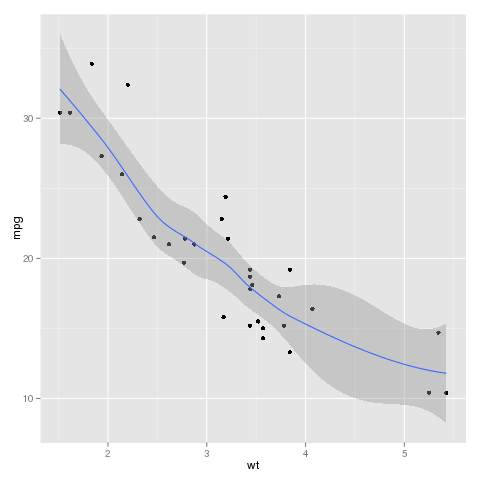

In [41]:
%%R
library(ggplot2)
suppressPackageStartupMessages(
    ggplot(mtcars, aes(x=wt, y=mpg)) + geom_point() + geom_smooth(method=loess)
)

#### Converting between Python and R

In [42]:
%R -o mtcars

#### `mtcars` is now a Python dataframe

In [43]:
mtcars.head(n=3)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108,93,3.85,2.320,18.61,1,1,4,1


#### We can also pass data from Ptyhon to R

In [44]:
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

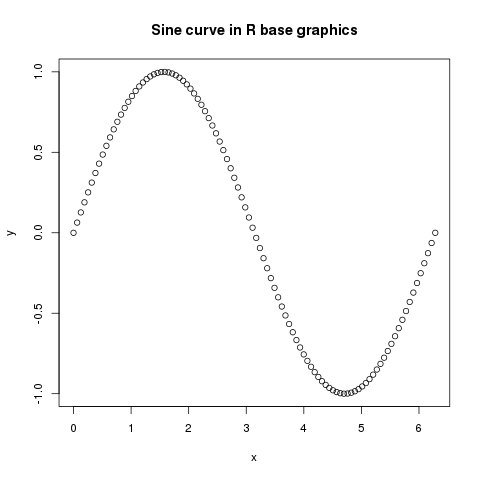

In [45]:
%%R -i x,y
plot(x, y, main="Sine curve in R base graphics")